# Survival Analysis Template

Imports

In [1]:
import pandas as pd
import cptac
import cptac.utils as ut
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
'''
Params
cancer_object: Object. The loaded cancer data set.
all_prot: List. trans proteins used to get proteomics data. 
gene_in: String. Gene used to get mutation status for the Mutation col.
utils: utils package from cptac.  

Returns a dataframe with trans proteomics and mutation status of a specific gene.
'''

def all_prot_format_df(cancer_object, all_prot, gene_in = 'PTEN', utils = ut):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    
    if cancer_object.get_cancer_type() not in ('luad', 'endometrial'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot, tissue_type = 'tumor')
        # Reduce a multiindex 
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            prot_and_mutations = utils.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)
            prot_and_mutations = rename_duplicate_cols(prot_and_mutations)
        
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] 
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type)
        
        # Keep only Wildtype and deletion
        compare = ['Wildtype_Tumor','Deletion']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
    
    
    # Luad has no somatic mutations for PTEN which changes some things
    elif cancer_object.get_cancer_type() in ('luad'): 
        # get_genotype_all_vars add cnv data under the column PTEN
        mut_type = mut_type.drop(columns= gene_in)
        # different code because no somatic mutation data for pten (can't join to somatic mutations)
        omics = cancer_object.join_omics_to_omics(df1_name = 'CNV', df2_name='proteomics',genes1= gene_in, 
            genes2= all_prot, tissue_type = 'tumor')
        omics = utils.reduce_multiindex(omics, levels_to_drop = 1, flatten = True)
        omics = rename_duplicate_cols(omics)
        omics = omics.drop(columns='PTEN_CNV')
       
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        merged = omics.join(mut_type) 
        # Keep only No_Mutation (wildtype) and deletion
        compare = ['No_Mutation','Deletion']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
        mut_wt['Mutation'] = np.where(
            mut_wt['Mutation'] == 'No_Mutation', 'Wildtype_Tumor', 'Deletion')
        
    elif cancer_object.get_cancer_type() in ('endometrial'):
        # merge cnv with genotype all mut type
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot, tissue_type = 'tumor') # drop Normal samples

        prot_df = prot_and_mutations.iloc[:,:-4] #drop Mutation and Location cols
        mut_type = mut_type[['Mutation']] # Get Mutation col that includes CNV
        merged = prot_df.join(mut_type) # merge 

        # Create Truncation category and keep truncation and wt
        compare = ['Wildtype_Tumor','Nonsense_Mutation','Frame_Shift_Ins','Frame_Shift_Del']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
        mut_wt['Mutation'] = np.where(
                        mut_wt['Mutation'] == 'Wildtype_Tumor', 'Wildtype_Tumor', 'Truncation')
    
    mut_wt = mut_wt.rename(columns={col: re.sub(r'_proteomics', '', col) for col in mut_wt.columns.tolist()})
    return mut_wt


In [5]:
''' Adds '_i' to duplicate col names where the int i increases by one with each duplicate 
Returns a df with unique column names. '''

def rename_duplicate_cols(df):
    cols = pd.Series(df.columns[:])

    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

    # rename the columns with the cols list.
    df.columns=cols
    return df

In [ ]:
def get_survival_cols(cancer_object):
    cancer = cancer_object.get_cancer_type()
    #print(cancer)
    
    # get unique survival col names
    if cancer == 'gbm':
        cols = ['vital_status', 'path_diag_to_last_contact_days', 'path_diag_to_death_days']
    if cancer == 'hnscc':
        cols = ['VITAL_STATUS', 'PATHO_DIAG_TO_LAST_CONT_DAYS', 'PATHO_DIAG_TO_DEATH_DAYS']
    if cancer == 'luad':
        cols = ['Vital Status', 'Path Diag to Last Contact(Day)', 'Path Diag to Death(days)']
    if cancer == 'ovarian':
        cols = ['Vital_Status', 'Days_Between_Collection_And_Last_Contact', 'Days_Between_Collection_And_Death']
    if cancer == 'endometrial':
        cols = ['Vital Status', 'Path Diag to Last Contact(Day)', 'Path Diag to Death(days)']
    
    # lscc no follow up or clin matching survival cols

    if cancer == 'brca':
        cols = ['Vital Status (at time of last contact)'] 
        print('Use csv')
    if cancer == 'colon':
        cols = ['Vital Status (at time of last contact)'] 
        print('Use csv')

    return cols

# Step 1: Import cancer data

Choose cancer.

In [7]:
brain = cptac.Gbm()
#kidney = cptac.Ccrcc()
#ovar = cptac.Ovarian()
#colon = cptac.Colon()
#brca = cptac.Brca()
#luad = cptac.Luad()
#hnscc = cptac.Hnscc()
#lscc = cptac.Lscc()

# Step 2: Get df with driver status

Import a dataframe for the the driver you are interested in. The index should be the Patient_ID and the first column should contain if the patient has the driver.

In [ ]:
has_driver = pd.read_csv('GBM_has_driver.csv', index_col=0)
has_driver.head()

In [43]:
days = pd.read_csv('CO_days_to_last_contact_or_death.csv') 
days = days.set_index('Patient_ID')

clin = ca.get_clinical(tissue_type = 'tumor')
clin = clin.rename(columns = {'Vital.Status': 'vital_status'}) #(at time of last contact)
status = clin[['vital_status']]
survival_df = status.join(days, how = 'right') # keep samples with day values
survival_df

,vital_status,days_to_last_contact,days_to_death
Patient_ID,,,
01CO001,Living,390.0,NaN
01CO005,Deceased,NaN,531.0
01CO006,Living,365.0,NaN
01CO008,Living,369.0,NaN
01CO013,Living,155.0,NaN
...,...,...,...
21CO006,Living,368.0,NaN
21CO007,Living,279.0,NaN
22CO004,Living,346.0,NaN


In [52]:
#df = get_survival_cols(ca) # get 'vital_status', 'days_to_last_contact', 'days_to_death'

del_wt = all_prot_format_df(ca, ['PTEN']) # get Mutation col (PTEN del/wt)
mut_survival = survival_df.join(del_wt, on = 'Patient_ID') # combine keeping samples with day values
mut_survival

,vital_status,days_to_last_contact,days_to_death,PTEN,Mutation
Patient_ID,,,,,
01CO001,Living,390.0,NaN,NaN,Wildtype_Tumor
01CO005,Deceased,NaN,531.0,NaN,Deletion
01CO006,Living,365.0,NaN,-0.111,Wildtype_Tumor
01CO008,Living,369.0,NaN,NaN,Wildtype_Tumor
01CO013,Living,155.0,NaN,-0.582,Wildtype_Tumor
...,...,...,...,...,...
21CO006,Living,368.0,NaN,-0.109,Wildtype_Tumor
21CO007,Living,279.0,NaN,-0.324,Wildtype_Tumor
22CO004,Living,346.0,NaN,0.200,Wildtype_Tumor


# Step 3: Kaplan Meier Plotting

Kaplan Meier plots show the probability of some event occuring over a given length of time, based on some attribute(s). 

In [53]:
#Make the vital_status column boolean
mut_survival['vital_status'] = mut_survival['vital_status'].replace('Living', False)
mut_survival['vital_status'] = mut_survival['vital_status'].replace('Deceased', True)
mut_survival['vital_status'] = mut_survival['vital_status'].astype('bool')

# Create one column with days between last contact or death
days = ['days_to_last_contact', 'days_to_death']
df_genes = mut_survival.assign(days_to_last_contact_or_death = mut_survival[days].sum(1)).drop(days, 1)

In [54]:
df_genes

,vital_status,PTEN,Mutation,days_to_last_contact_or_death
Patient_ID,,,,
01CO001,False,NaN,Wildtype_Tumor,390.0
01CO005,True,NaN,Deletion,531.0
01CO006,False,-0.111,Wildtype_Tumor,365.0
01CO008,False,NaN,Wildtype_Tumor,369.0
01CO013,False,-0.582,Wildtype_Tumor,155.0
...,...,...,...,...
21CO006,False,-0.109,Wildtype_Tumor,368.0
21CO007,False,-0.324,Wildtype_Tumor,279.0
22CO004,False,0.200,Wildtype_Tumor,346.0


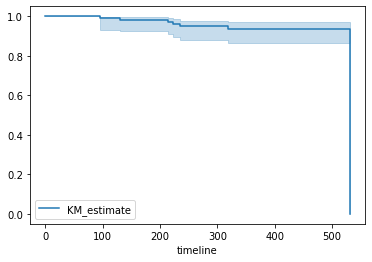

In [55]:
# Plot
time = df_genes['days_to_last_contact_or_death']
status = df_genes['vital_status']

kmf = KaplanMeierFitter()
kmf.fit(time, event_observed = status)
kmf.plot()

# Step 4: Prepare Data for Multivariate Kaplan Meier Plots and Cox's Proportional Hazard Test

In [59]:
# map numeric values to correspond with mutation status
mutation_map = {"Wildtype_Tumor" : 0, "Deletion" : 1}

df_genes['PTEN'] = df_genes['Mutation'].map(mutation_map)

#Then we will drop missing values, as missing values 
#will throw an error in the functions we will use in lifelines.
df_clean = df_genes.dropna(axis=0, how='any').copy()
df_clean = df_clean.drop(columns= 'Mutation') # drop col with str values (info mapped to PTEN as int)
df_clean

,vital_status,PTEN,days_to_last_contact_or_death
Patient_ID,,,
01CO001,False,0.0,390.0
01CO005,True,1.0,531.0
01CO006,False,0.0,365.0
01CO008,False,0.0,369.0
01CO013,False,0.0,155.0
...,...,...,...
21CO006,False,0.0,368.0
21CO007,False,0.0,279.0
22CO004,False,0.0,346.0


In [67]:
df_clean.loc[df_clean['vital_status'] == True]

,vital_status,PTEN,days_to_last_contact_or_death
Patient_ID,,,
01CO005,True,1.0,531.0
05CO015,True,0.0,130.0
05CO039,True,0.0,214.0
11CO021,True,0.0,95.0
11CO044,True,0.0,235.0
11CO052,True,0.0,223.0
20CO003,True,0.0,318.0


In [68]:
df_clean.loc[['22CO006']]

,vital_status,PTEN,days_to_last_contact_or_death
Patient_ID,,,
22CO006,False,0.0,403.0


In [70]:
len(df_clean.loc[df_clean['PTEN'] == 1])

25

Verify that your columns are the correct data types.  The event of interest, in this case Vital_Status needs to contain boolean values, and all other columns in the table must be of a numeric type (either int64 or float64).

In [57]:
for col in df_clean.columns:
    print(col, ":", df_clean[col].dtype)

vital_status : bool
PTEN : float64
days_to_last_contact_or_death : float64


# Step 5: Plot Multivariate Survival Risk

1 is wt. 2 is mutant.

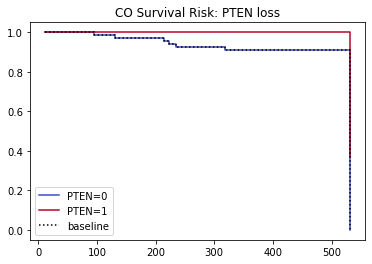

In [61]:
cph = CoxPHFitter()
cph.fit(df_clean, duration_col = "days_to_last_contact_or_death", 
        event_col = "vital_status")

plot_title = cancer+" Survival Risk: PTEN loss"
cph.plot_partial_effects_on_outcome('PTEN', [0,1], cmap='coolwarm', title=plot_title)
    

In [62]:
cph.print_summary(model="untransformed variables", decimals=3)


<lifelines.CoxPHFitter: fitted with 98 total observations, 91 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 98
number of events observed = 7
   partial log-likelihood = -25.019
         time fit was run = 2020-10-26 20:36:48 UTC
                    model = untransformed variables

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
PTEN      -16.277      0.000   2338.832        -4600.303         4567.749                0.000                  inf

               z     p   -log2(p)
covariate                        
PTEN      -0.007 0.994      0.008
---
Concordance = 0.633
Partial AIC = 52.039
log-likelihood ratio test = 3.664 on 1 df
-log2(p) of ll-ratio test = 4.169

# Step 6: Cox's Proportional Hazard Test

With the proportional_hazard_test function, we can now perform Cox's Proportional Hazard Test on the data to determine how each attribute contributes to our cohort's overall survival. This is shown by the hazard ratio in the column labeled -log2(p) below. In general, a hazard ratio of 1 suggests that an attribute has no effect on overall survival. A ratio less than 1 suggests that an attribute contributes to lower survival risk. A ratio greater than 1 suggests that an attribute contributes to higher survival risk.

In [63]:
results = proportional_hazard_test(cph, df_clean, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 98 total observations, 91 right-censored observations>
         test_name = proportional_hazard_test

---
      test_statistic    p  -log2(p)
PTEN            0.00 1.00      0.00

Below, we show the confidence interval for the hazard ratio. 

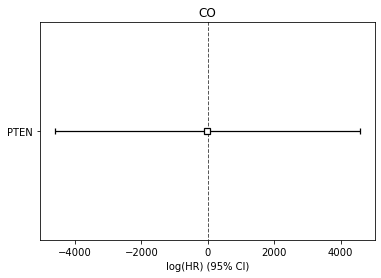

In [64]:
plt.title(cancer)
cph.plot()

In [ ]:
# log(hazards ratio) = coef = -0.192

Conclusions: Because the p-value was greater than 0.05, there is insufficient evidence to suggest the PTEN loss effects survival risk.